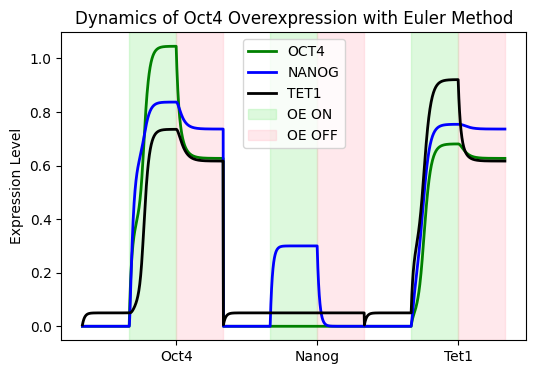

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants from the model
Kd = 0.1           # Dimerization constant for Nanog-Tet1 complex
KO = 0.3           # Dissociation constant for Oct4
KNT = 0.2          # Dissociation constant for Nanog-Tet1 complex
n = 2              # Hill coefficient

# Promoter activity constants for Nanog, Oct4, and Tet1
pN = pO = pT = 1

# Initial steady-state values when no overexpression
initial_state = [0, 0, 0]  # [N_total, O_total, T_total]

# Function to calculate [N|T] complex formation
def NT_complex(N_total, T_total, Kd):
    term = (Kd + N_total + T_total) / 2
    return term - np.sqrt(term**2 - N_total * T_total)

# ODEs representing the system
def gene_network(y, Nover, Oover, Tover, Lif, pN, pO, pT):
    N_total, O_total, T_total = y
    # Calculate the [N|T] complex
    NT_complex_value = NT_complex(N_total, T_total, Kd)

    # ODEs for Nanog, Oct4, and Tet1
    dN_dt = Nover + Lif + pN * (O_total / KO) / (1 + (O_total / KO)) - N_total
    dO_dt = Oover + Lif + pO * (NT_complex_value / KNT)**n / (1 + (NT_complex_value / KNT)**n) * (O_total / KO) / (1 + (O_total / KO)) - O_total
    dT_dt = Tover + pT * (NT_complex_value / KNT)**n / (1 + (NT_complex_value / KNT)**n) * (O_total / KO) / (1 + (O_total / KO)) - T_total

    return [dN_dt, dO_dt, dT_dt]

# Define the overexpression parameters for (N, O, T), LIF (Adjust with different parameters) ##LIF = 0.06 when it is a pluripotent cell
def overexpression_step(t):
    if t < 20:
        return (0, 0, 0.05), 0  # Stay in initial steady state
    elif 20 <= t < 40:
        return (0, 0.3, 0.05), 0.06 # Oct4 overexpression ON
    elif 40 <= t < 60:
        return (0, 0, 0.05), 0.06  # Oct4 overexpression OFF
    elif 60 <= t < 80:
        return (0, 0, 0.05), 0 # initial steady state
    elif 80 <= t < 100:
        return (0.3, 0, 0.05), 0  # Nanog overexpression ON
    elif 100 <= t < 120:
        return (0, 0, 0.05), 0 # Nanog overexpression OFF
    elif 120 <= t < 140:
        return (0, 0, 0.05), 0  # initial steady state
    elif 140 <= t < 160:
        return (0, 0, 0.3), 0.06 # Tet1 overexpression OFF
    elif 160 <= t < 180:
        return (0, 0, 0.05), 0.06  # Tet1 overexpression OFF


# Euler method implementation (?)
def euler_method(y0, t, step_size):
    N_total_values, O_total_values, T_total_values = [], [], []
    y = y0  # initial condition

    for i in range(len(t)-1):
        # Get overexpression parameters at current time

        if i % 600 == 0 and i != 0:
            y = y0
        (Nover, Oover, Tover), Lif = overexpression_step(t[i])
        # Compute the derivatives using the current values
        dydt = gene_network(y, Nover, Oover, Tover, Lif, pN, pO, pT)

        # Update the values using Euler's method
        y = [y[j] + step_size * dydt[j] for j in range(len(y))]

        # Store the results
        N_total_values.append(y[0])
        O_total_values.append(y[1])
        T_total_values.append(y[2])

    return np.array(N_total_values), np.array(O_total_values), np.array(T_total_values)

# Time vector and step size for Euler method (?)
t = np.linspace(0, 180, 1800)
step_size = t[1] - t[0]

# Solve the system using Euler's method
N_total_values, O_total_values, T_total_values = euler_method(initial_state, t, step_size)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(t[:-1], O_total_values, label='OCT4', color='green', linewidth=2)
plt.plot(t[:-1], N_total_values, label='NANOG', color='blue', linewidth=2)
plt.plot(t[:-1], T_total_values, label='TET1', color='black', linewidth=2)

# Add background colors for overexpression phases
plt.axvspan(20, 40, color='lightgreen', alpha=0.3, label='OE ON')
plt.axvspan(40, 60, color='lightpink', alpha=0.3, label='OE OFF')
plt.axvspan(80, 100, color='lightgreen', alpha=0.3)
plt.axvspan(100, 120, color='lightpink', alpha=0.3)
plt.axvspan(140, 160, color='lightgreen', alpha=0.3)
plt.axvspan(160, 180, color='lightpink', alpha=0.3)

categories = ['Oct4', 'Nanog', 'Tet1']
plt.xticks([40,100,160], labels = categories)
#plt.xlabel('Time')
plt.ylabel('Expression Level')
plt.title('Dynamics of Oct4 Overexpression with Euler Method')
plt.legend()
plt.show()